In [17]:
from pathlib import Path
import numpy as np
import pandas as pd
import hdbscan
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score
import seaborn as sns

import folium
import numpy as np
from IPython.display import display

In [18]:
full_df = pd.read_pickle('../../data/processed/state2/left_android_df.pkl')
print(full_df.columns.tolist())
features = [
    'gyroAngleChange', 
    'gyro_angular_change_per_second',
    'radius_log',
    'turn_intensity',
    'angle_norm'
]
df = full_df[features].copy()
print(df.columns.to_list())
print(df.shape)

['eventSampleSpeed', 'eventDurationSeconds', 'eventStartSpeed', 'eventEndSpeed', 'eventMilesDriven', 'memsMedianLateralAccel', 'gyro_angular_change_per_second', 'gyroAngleChange', 'mems_radius', 'dv', 'turn_intensity', 'angle_norm', 'radius_log']
['gyroAngleChange', 'gyro_angular_change_per_second', 'radius_log', 'turn_intensity', 'angle_norm']
(249, 5)


In [19]:
def calculate_gini_score(labels) -> float:
    # Exclude HDBSCAN/DBSCAN noise
    labels = np.asarray(labels)
    mask = labels != -1
    if mask.sum() == 0:
        return 0.0
    # Counts per cluster
    counts = np.bincount(labels[mask])
    counts = counts[counts > 0].astype(float)
    if counts.size <= 1:
        return 0.0
    # Pairwise Gini
    G = np.abs(counts[:, None] - counts[None, :]).sum() / (2 * counts.size * counts.sum())
    # Normalize so 1.0 = maximally imbalanced given k clusters
    Gmax = (counts.size - 1) / counts.size
    return float(G / Gmax) if Gmax else 0.0

In [20]:
X_scaled = StandardScaler().fit_transform(df)
scaled_df = pd.DataFrame(X_scaled, columns=df.columns, index=df.index)
features_to_plot = features[:]   # keep plotting consistent with model inputs

In [21]:
# k means model
results_list = []
# possible k values
for k in [2, 3, 4, 5]:
    kmeans_final = KMeans(n_clusters=k, random_state=42)
    kmeans_final.fit(X_scaled)
    final_labels = kmeans_final.labels_

    sil_score = silhouette_score(X_scaled, final_labels)
    noise_percentage = 0.0
    gini_score = calculate_gini_score(final_labels)

    results_list.append({
        'model': 'kmeans',
        'sil. #': sil_score,
        'Gini': gini_score,
        'noise %': noise_percentage,
        'clust. #': k
    })    


In [22]:
N_total = X_scaled.shape[0]

In [23]:
# DBSCAN
for eps in np.linspace(0.1, 2.0, 20):
    for min_pts in range(3, 20):
        labels = DBSCAN(eps=float(eps), min_samples=int(min_pts), n_jobs=-1).fit_predict(X_scaled)
        mask = labels != -1
        labels_nn = labels[mask]
        n_clusters = len(np.unique(labels_nn))
        n_noise = int((labels == -1).sum())
        noise_pct = (n_noise / N_total) * 100.0

        if not (2 <= n_clusters <= 5) or labels_nn.size < 2:
            continue

        sil = silhouette_score(X_scaled[mask], labels_nn)
        gini = calculate_gini_score(labels)
        results_list.append({
            'model': 'dbscan',
            'HP (eps)': float(eps),
            'HP (min_samp)': int(min_pts),
            'clust. #': int(n_clusters),
            'sil. #': float(sil),
            'Gini': float(gini),
            'noise %': float(noise_pct),
        })

In [24]:
#HDBSCAN
N_total = X_scaled.shape[0]

for min_samp in range(2, 10):
    for min_cluster_size in range(8, 25):

        # Optional: prune combos that tend not to help
        if min_samp > min_cluster_size:
            continue

        clusterer = hdbscan.HDBSCAN(
            min_samples=min_samp,
            min_cluster_size=min_cluster_size,
            metric='euclidean'  # explicit; change if you need
        )
        clusterer.fit(X_scaled)
        labels = clusterer.labels_

        non_noise_mask = labels != -1
        labels_non_noise = labels[non_noise_mask]
        n_non_noise = labels_non_noise.size
        n_clusters = len(np.unique(labels_non_noise)) if n_non_noise else 0

        n_noise = np.count_nonzero(labels == -1)
        noise_percentage = (n_noise / N_total) * 100.0

        # Default
        sil_score = np.nan

        # Only try silhouette when it makes sense
        if noise_percentage < 15 and n_clusters >= 2 and n_non_noise >= 2:
            try:
                sil_score = silhouette_score(X_scaled[non_noise_mask], labels_non_noise)
            except ValueError:
                # e.g., pathological spacing or degenerate cluster shapes
                sil_score = np.nan

        gini_score = calculate_gini_score(labels)  # must ignore -1 internally

        results_list.append({
            'model': 'hdbscan',
            'HP (min_samp)': min_samp,
            'HP (min_clust)': min_cluster_size,
            'sil. #': sil_score,
            'Gini': gini_score,
            'noise %': noise_percentage,
            'clust. #': n_clusters
        })

/Users/shazi/Documents/VS Code/Arity - BTT Project 1/ARITY-BTT-PROJECT-1/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/shazi/Documents/VS Code/Arity - BTT Project 1/ARITY-BTT-PROJECT-1/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/shazi/Documents/VS Code/Arity - BTT Project 1/ARITY-BTT-PROJECT-1/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/shazi/Documents/VS Code/Arity - BTT Project 1/ARITY-BTT-PROJECT-1/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' 

In [25]:
results_df = pd.DataFrame(results_list)
results_df.head

<bound method NDFrame.head of        model    sil. #      Gini    noise %  clust. #  HP (eps)  \
0     kmeans  0.420848  0.293173   0.000000         2       NaN   
1     kmeans  0.354830  0.305221   0.000000         3       NaN   
2     kmeans  0.394370  0.451138   0.000000         4       NaN   
3     kmeans  0.309415  0.373494   0.000000         5       NaN   
4     dbscan  0.968084  0.000000  97.590361         2       0.1   
..       ...       ...       ...        ...       ...       ...   
236  hdbscan       NaN  0.604396  26.907631         2       NaN   
237  hdbscan       NaN  0.604396  26.907631         2       NaN   
238  hdbscan       NaN  0.604396  26.907631         2       NaN   
239  hdbscan       NaN  0.604396  26.907631         2       NaN   
240  hdbscan       NaN  0.604396  26.907631         2       NaN   

     HP (min_samp)  HP (min_clust)  
0              NaN             NaN  
1              NaN             NaN  
2              NaN             NaN  
3              Na

In [26]:
results_df = pd.DataFrame(results_list).sort_values(by=[ 'Gini', 'noise %', 'sil. #', 'clust. #',], ascending=[True,True, False, False])
filtered_results = results_df.reset_index().rename(columns={'index': 'run_id'})
filtered_results = filtered_results[filtered_results['noise %'] <= 20.0]
filtered_results = filtered_results[(filtered_results['clust. #'] >= 3)]
#filtered_results = filtered_results[filtered_results['Gini'] <= 0.9]
filtered_results = filtered_results[filtered_results['sil. #'] > 0.3]
(filtered_results.head(100))

,run_id,model,sil. #,Gini,noise %,clust. #,HP (eps),HP (min_samp),HP (min_clust)
3,1,kmeans,0.354830,0.305221,0.000000,3,NaN,NaN,NaN
5,3,kmeans,0.309415,0.373494,0.000000,5,NaN,NaN,NaN
6,2,kmeans,0.394370,0.451138,0.000000,4,NaN,NaN,NaN
211,64,dbscan,0.347220,0.739336,15.261044,3,0.8,8.0,NaN
212,65,dbscan,0.347220,0.739336,15.261044,3,0.8,9.0,NaN
218,48,dbscan,0.364817,0.746341,17.670683,3,0.7,6.0,NaN
223,66,dbscan,0.349516,0.762136,17.269076,3,0.8,10.0,NaN
225,80,dbscan,0.349346,0.770543,13.654618,4,0.9,12.0,NaN
226,47,dbscan,0.350325,0.771429,15.662651,3,0.7,5.0,NaN
230,76,dbscan,0.354096,0.962185,4.417671,3,0.9,3.0,NaN


In [27]:
#isolating top
filtered_results = filtered_results.loc[filtered_results['run_id'].isin([64, 48, 80, 76, 2])] # change to desired indices
filtered_results.head(60)

,run_id,model,sil. #,Gini,noise %,clust. #,HP (eps),HP (min_samp),HP (min_clust)
6,2,kmeans,0.394370,0.451138,0.000000,4,NaN,NaN,NaN
211,64,dbscan,0.347220,0.739336,15.261044,3,0.8,8.0,NaN
218,48,dbscan,0.364817,0.746341,17.670683,3,0.7,6.0,NaN
225,80,dbscan,0.349346,0.770543,13.654618,4,0.9,12.0,NaN
230,76,dbscan,0.354096,0.962185,4.417671,3,0.9,3.0,NaN


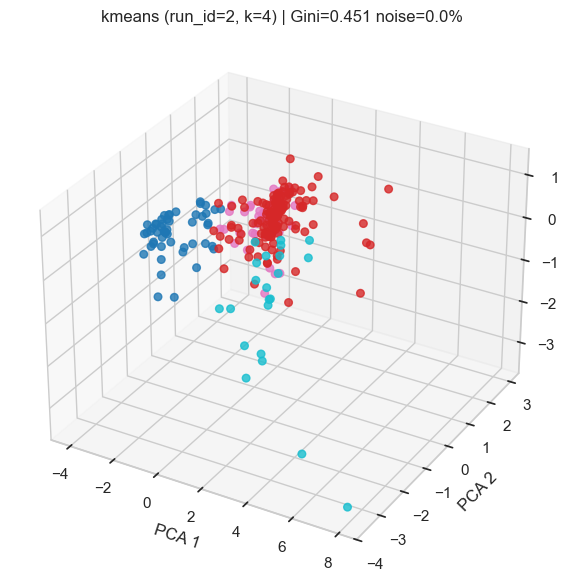

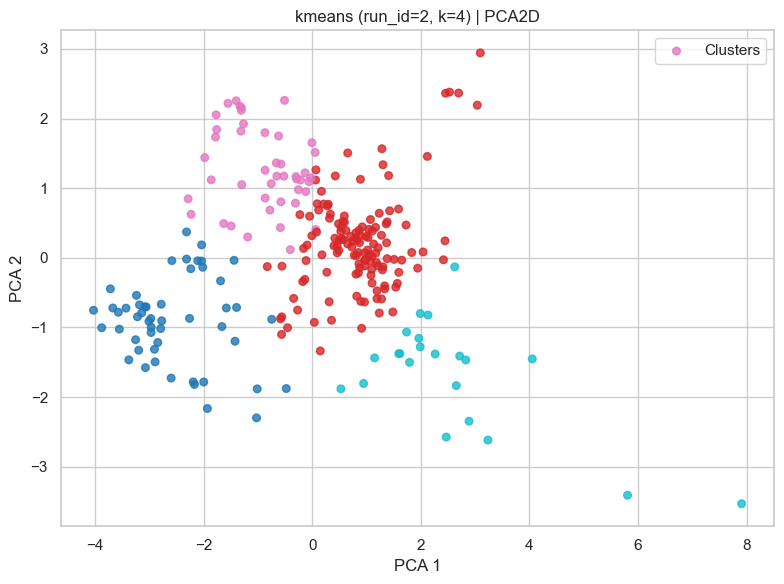

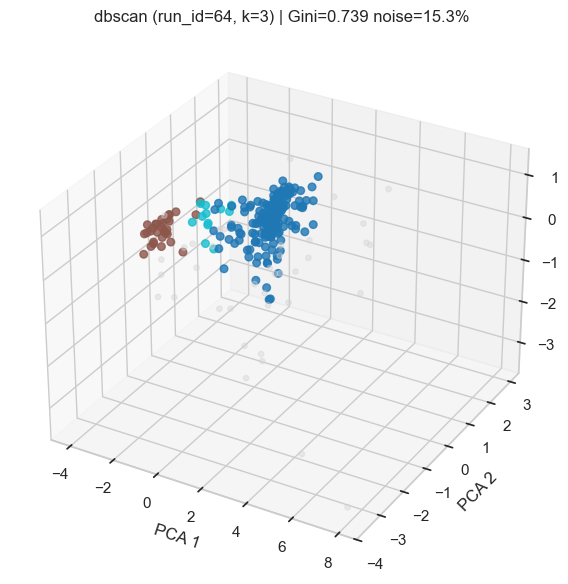

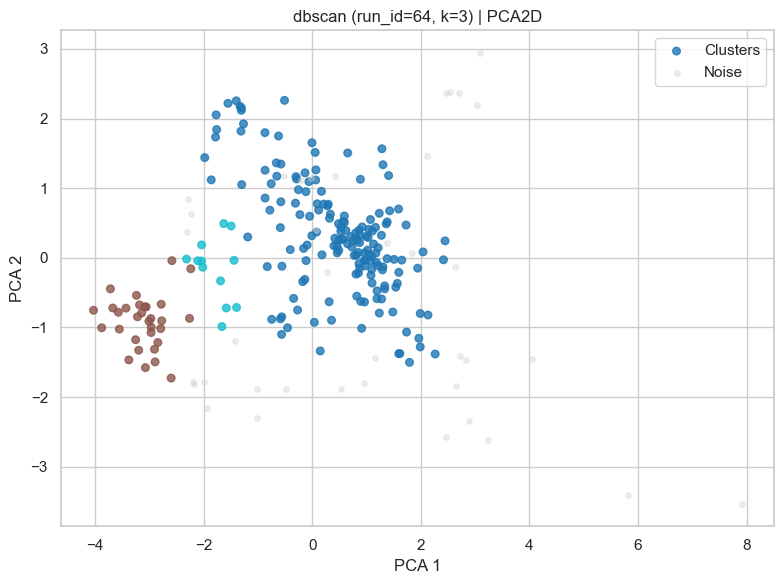

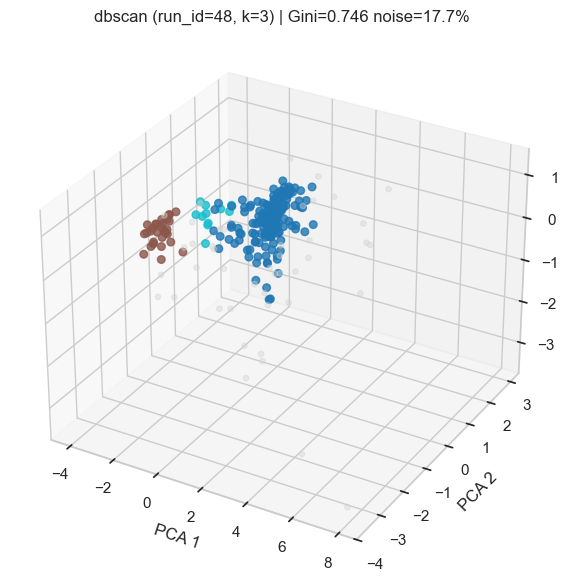

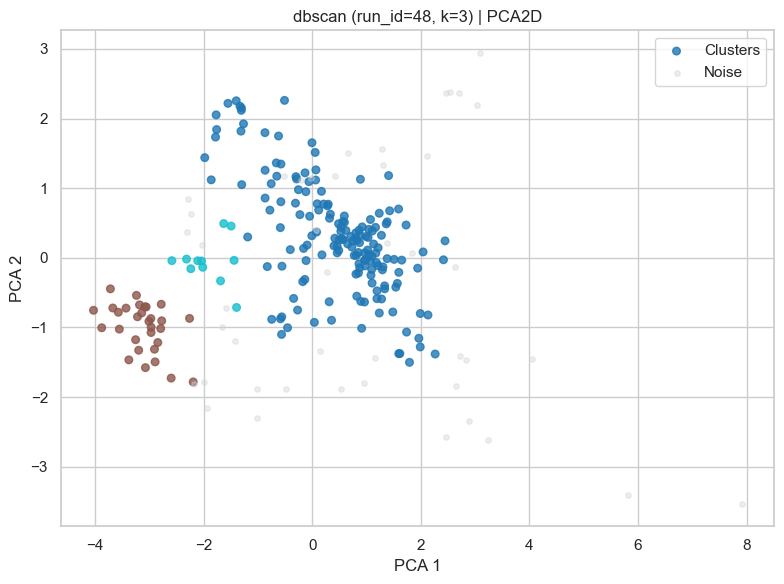

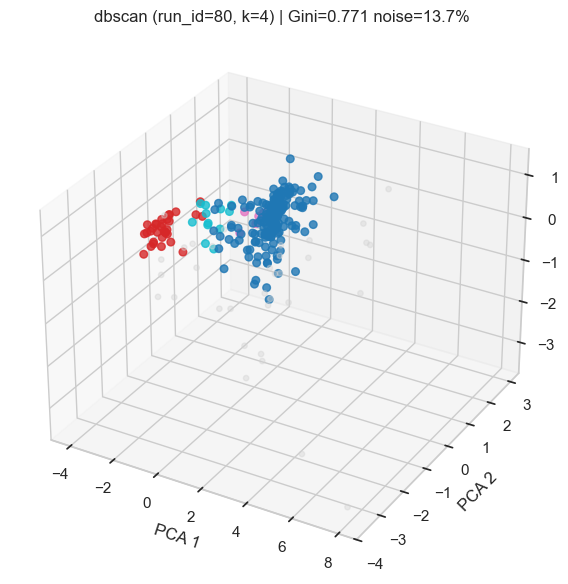

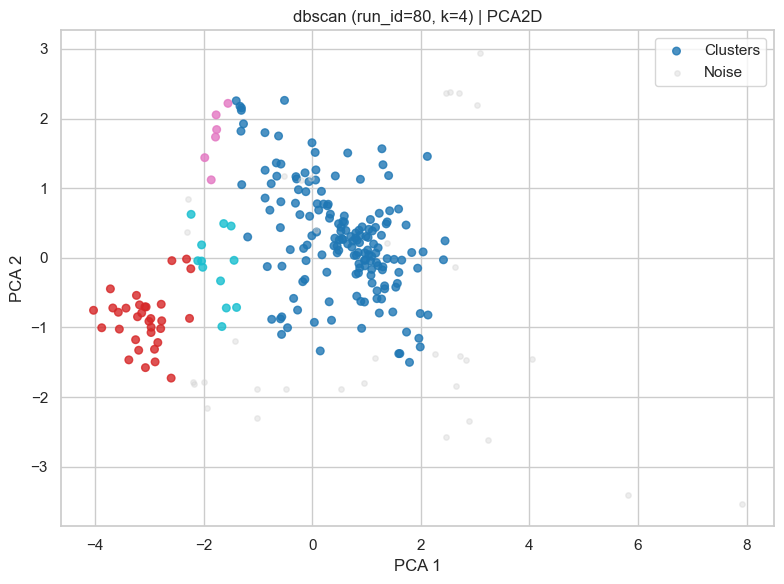

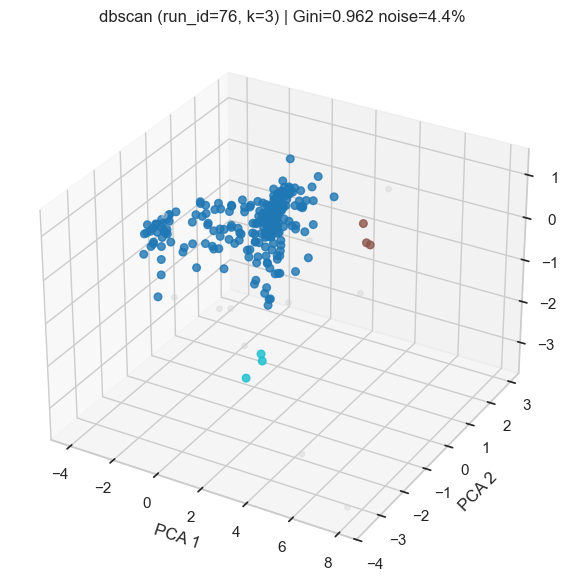

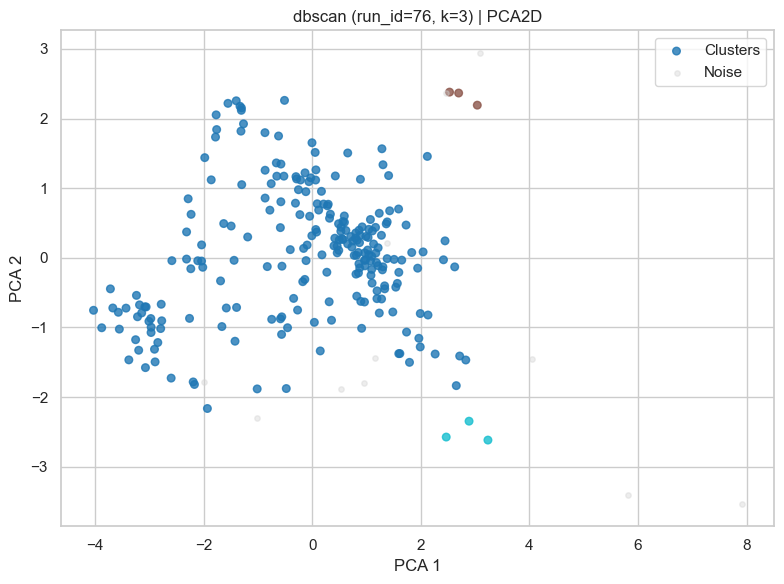

/var/folders/md/7qhzsnh55gzclxjx6wytnlh00000gn/T/ipykernel_38617/1142115120.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


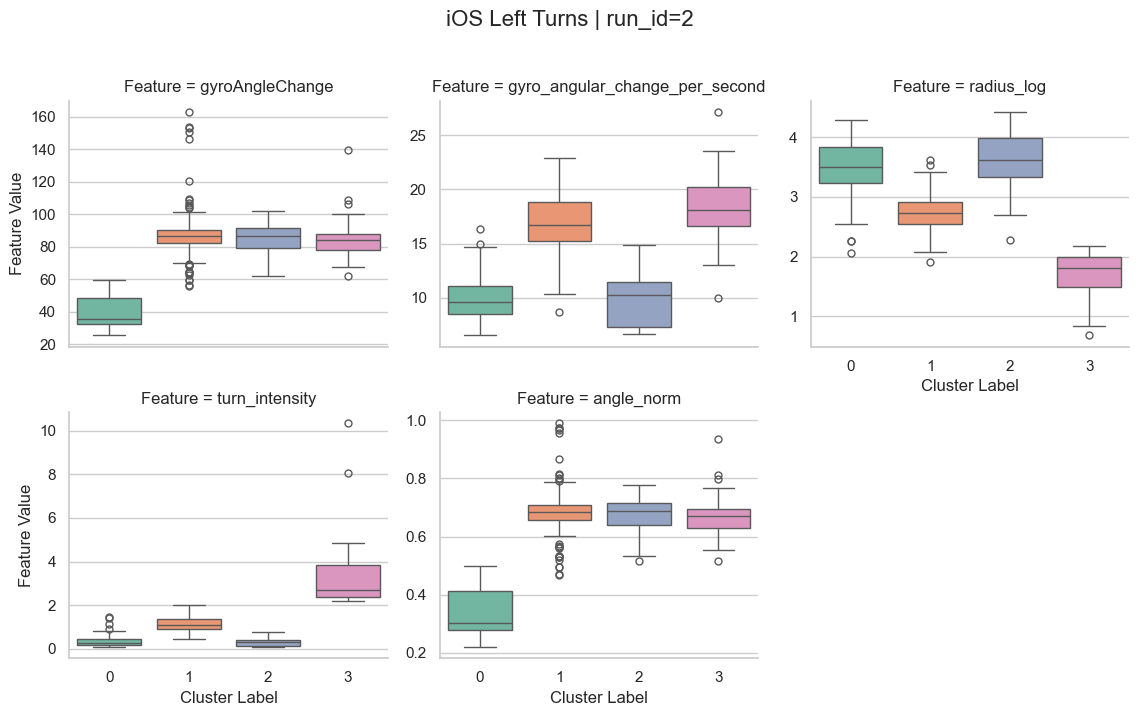

/var/folders/md/7qhzsnh55gzclxjx6wytnlh00000gn/T/ipykernel_38617/1142115120.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


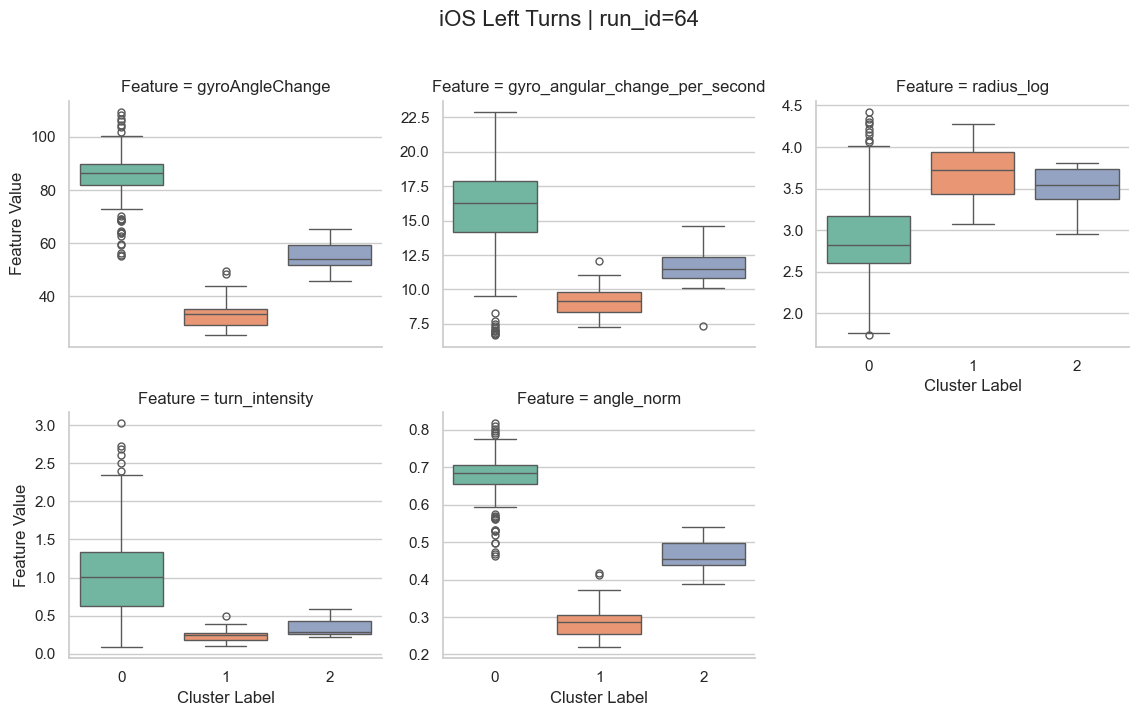

/var/folders/md/7qhzsnh55gzclxjx6wytnlh00000gn/T/ipykernel_38617/1142115120.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


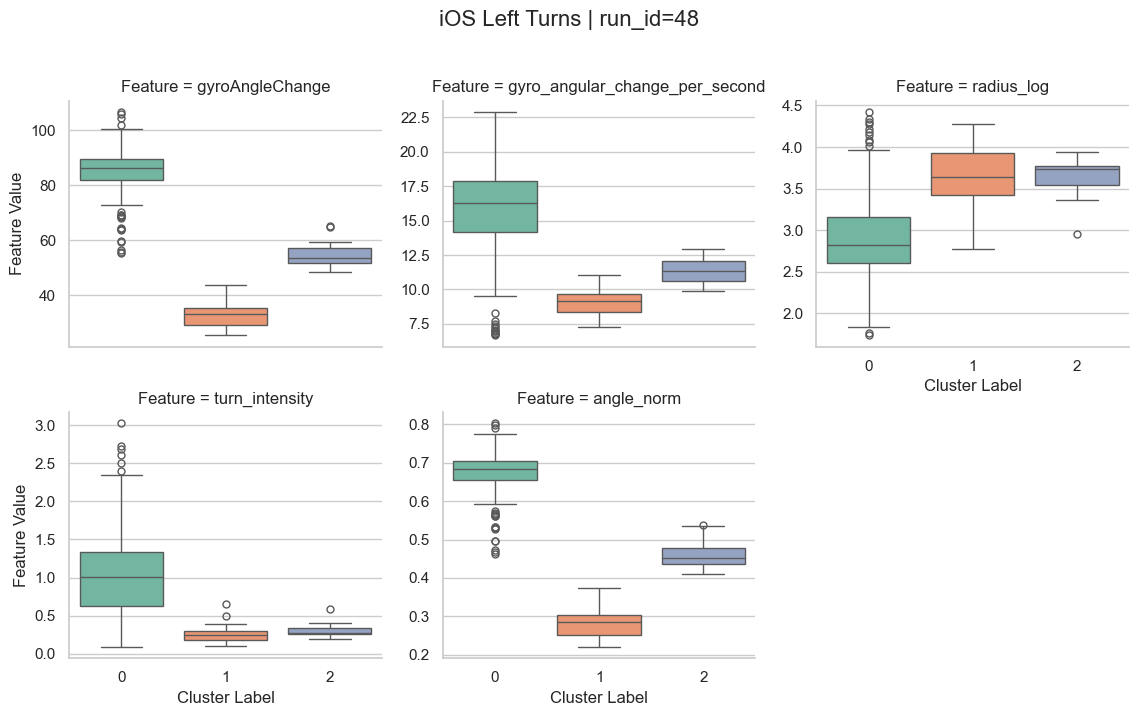

/var/folders/md/7qhzsnh55gzclxjx6wytnlh00000gn/T/ipykernel_38617/1142115120.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


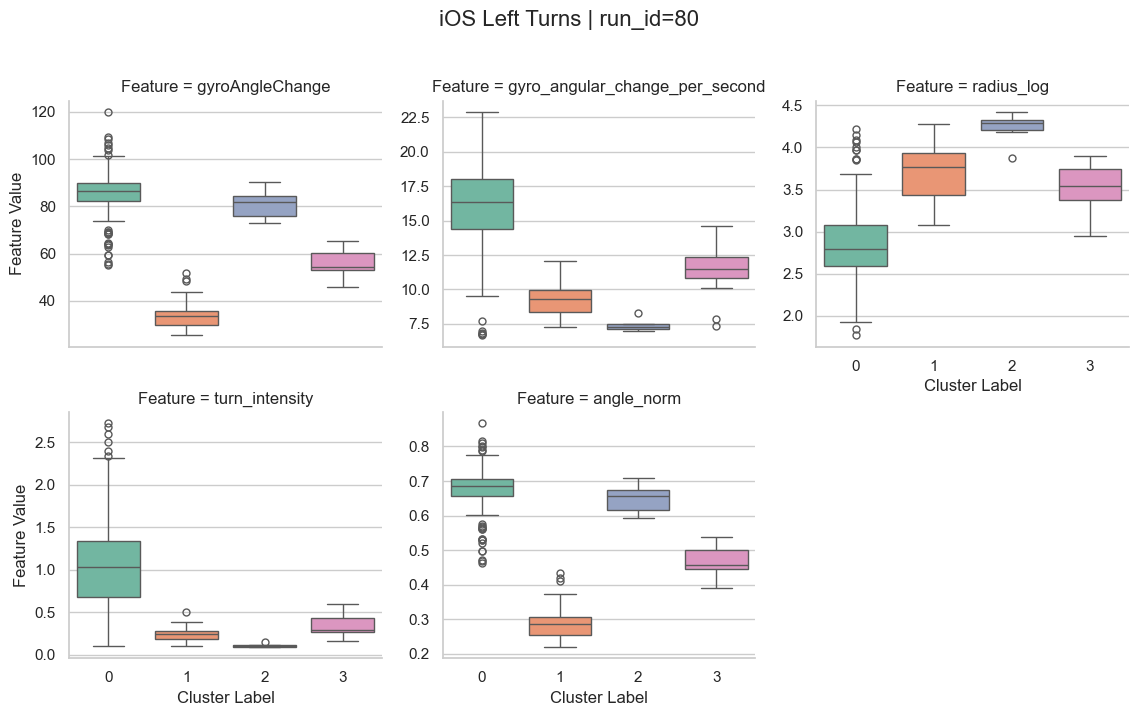

/var/folders/md/7qhzsnh55gzclxjx6wytnlh00000gn/T/ipykernel_38617/1142115120.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


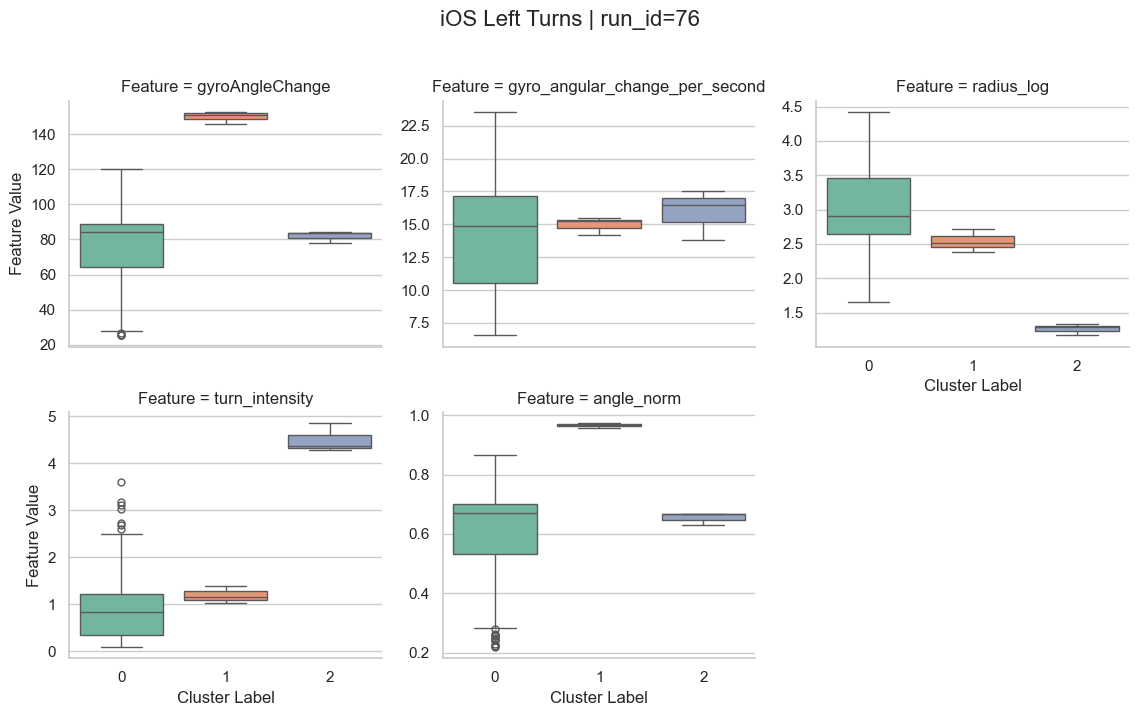

In [28]:
# --- CONFIG ---
runs_to_plot = filtered_results['run_id']       # run_id values you care about
plot_cols = ['gyroAngleChange',
             'gyro_angular_change_per_second',
             'radius_log',
             'turn_intensity',
             'angle_norm']

# --- helpers ---------------------------------------------------------------
def build_clusterer(row):
    model = row['model']
    if model == 'kmeans':
        return KMeans(n_clusters=int(row['clust. #']), random_state=42)
    if model == 'dbscan':
        return DBSCAN(eps=float(row['HP (eps)']),
                      min_samples=int(row['HP (min_samp)']),
                      n_jobs=-1)
    if model == 'hdbscan':
        return hdbscan.HDBSCAN(min_samples=int(row['HP (min_samp)']),
                               min_cluster_size=int(row['HP (min_clust)'])
                               if pd.notna(row['HP (min_clust)']) else None)
    raise ValueError(f"Unknown model '{model}' for run_id {row['run_id']}")

def attach_clusters(labels):
    df_with_clusters = full_df.copy()
    df_with_clusters['Cluster_Label'] = labels
    return df_with_clusters[df_with_clusters['Cluster_Label'] != -1].copy()

# --- 1) filter the runs once -----------------------------------------------
runs = (
    filtered_results
    .loc[filtered_results['run_id'].isin(runs_to_plot)]
    .copy()
)
if runs.empty:
    raise ValueError(f"No rows found for run_id(s) {runs_to_plot}")

# fit each clusterer exactly once and cache its labels
run_labels = {}
for _, row in runs.iterrows():
    clusterer = build_clusterer(row)
    run_labels[row['run_id']] = clusterer.fit_predict(X_scaled)

# --- 2) PCA plots ----------------------------------------------------------
pca3 = PCA(n_components=3).fit_transform(X_scaled)
pca2 = PCA(n_components=2).fit_transform(X_scaled)

for _, row in runs.iterrows():
    run_id = row['run_id']
    labels = run_labels[run_id]
    core_mask = labels != -1
    noise_mask = labels == -1
    title_bits = f"{row['model']} (run_id={run_id}, k={row['clust. #']})"

    # 3D
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pca3[core_mask, 0], pca3[core_mask, 1], pca3[core_mask, 2],
               c=labels[core_mask], cmap='tab10', s=30, alpha=0.8)
    if noise_mask.any():
        ax.scatter(pca3[noise_mask, 0], pca3[noise_mask, 1], pca3[noise_mask, 2],
                   c='lightgray', s=15, alpha=0.4, label='Noise')
    ax.set_title(f"{title_bits} | Gini={row['Gini']:.3f} noise={row['noise %']:.1f}%")
    ax.set_xlabel('PCA 1'); ax.set_ylabel('PCA 2'); ax.set_zlabel('PCA 3')
    plt.tight_layout(); plt.show()

    # 2D
    plt.figure(figsize=(8, 6))
    plt.scatter(pca2[core_mask, 0], pca2[core_mask, 1],
                c=labels[core_mask], cmap='tab10', s=30, alpha=0.8, label='Clusters')
    if noise_mask.any():
        plt.scatter(pca2[noise_mask, 0], pca2[noise_mask, 1],
                    c='lightgray', s=15, alpha=0.4, label='Noise')
    plt.title(f"{title_bits} | PCA2D")
    plt.xlabel('PCA 1'); plt.ylabel('PCA 2'); plt.legend(); plt.tight_layout(); plt.show()

# --- 3) Box plots ----------------------------------------------------------
for _, row in runs.iterrows():
    run_id = row['run_id']
    labels = run_labels[run_id]
    df_plot = attach_clusters(labels)
    df_plot['Cluster_Label'] = df_plot['Cluster_Label'].astype('category')

    melt_cols = [c for c in plot_cols if c in df_plot.columns]
    if not melt_cols:
        raise ValueError("No overlap between plot_cols and df columns.")

    df_melted = df_plot[['Cluster_Label'] + melt_cols].melt(
        id_vars='Cluster_Label', var_name='Feature', value_name='Value'
    )

    sns.set_style('whitegrid')
    g = sns.catplot(
        data=df_melted,
        x='Cluster_Label',
        y='Value',
        col='Feature',
        kind='box',
        col_wrap=3,
        palette='Set2',
        sharey=False,
        height=3.5,
        aspect=1.1
    )
    g.fig.suptitle(f'iOS Left Turns | run_id={run_id}', y=1.02, fontsize=16)
    g.set_axis_labels('Cluster Label', 'Feature Value')
    plt.tight_layout()
    plt.show()


/var/folders/md/7qhzsnh55gzclxjx6wytnlh00000gn/T/ipykernel_38617/1491362945.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


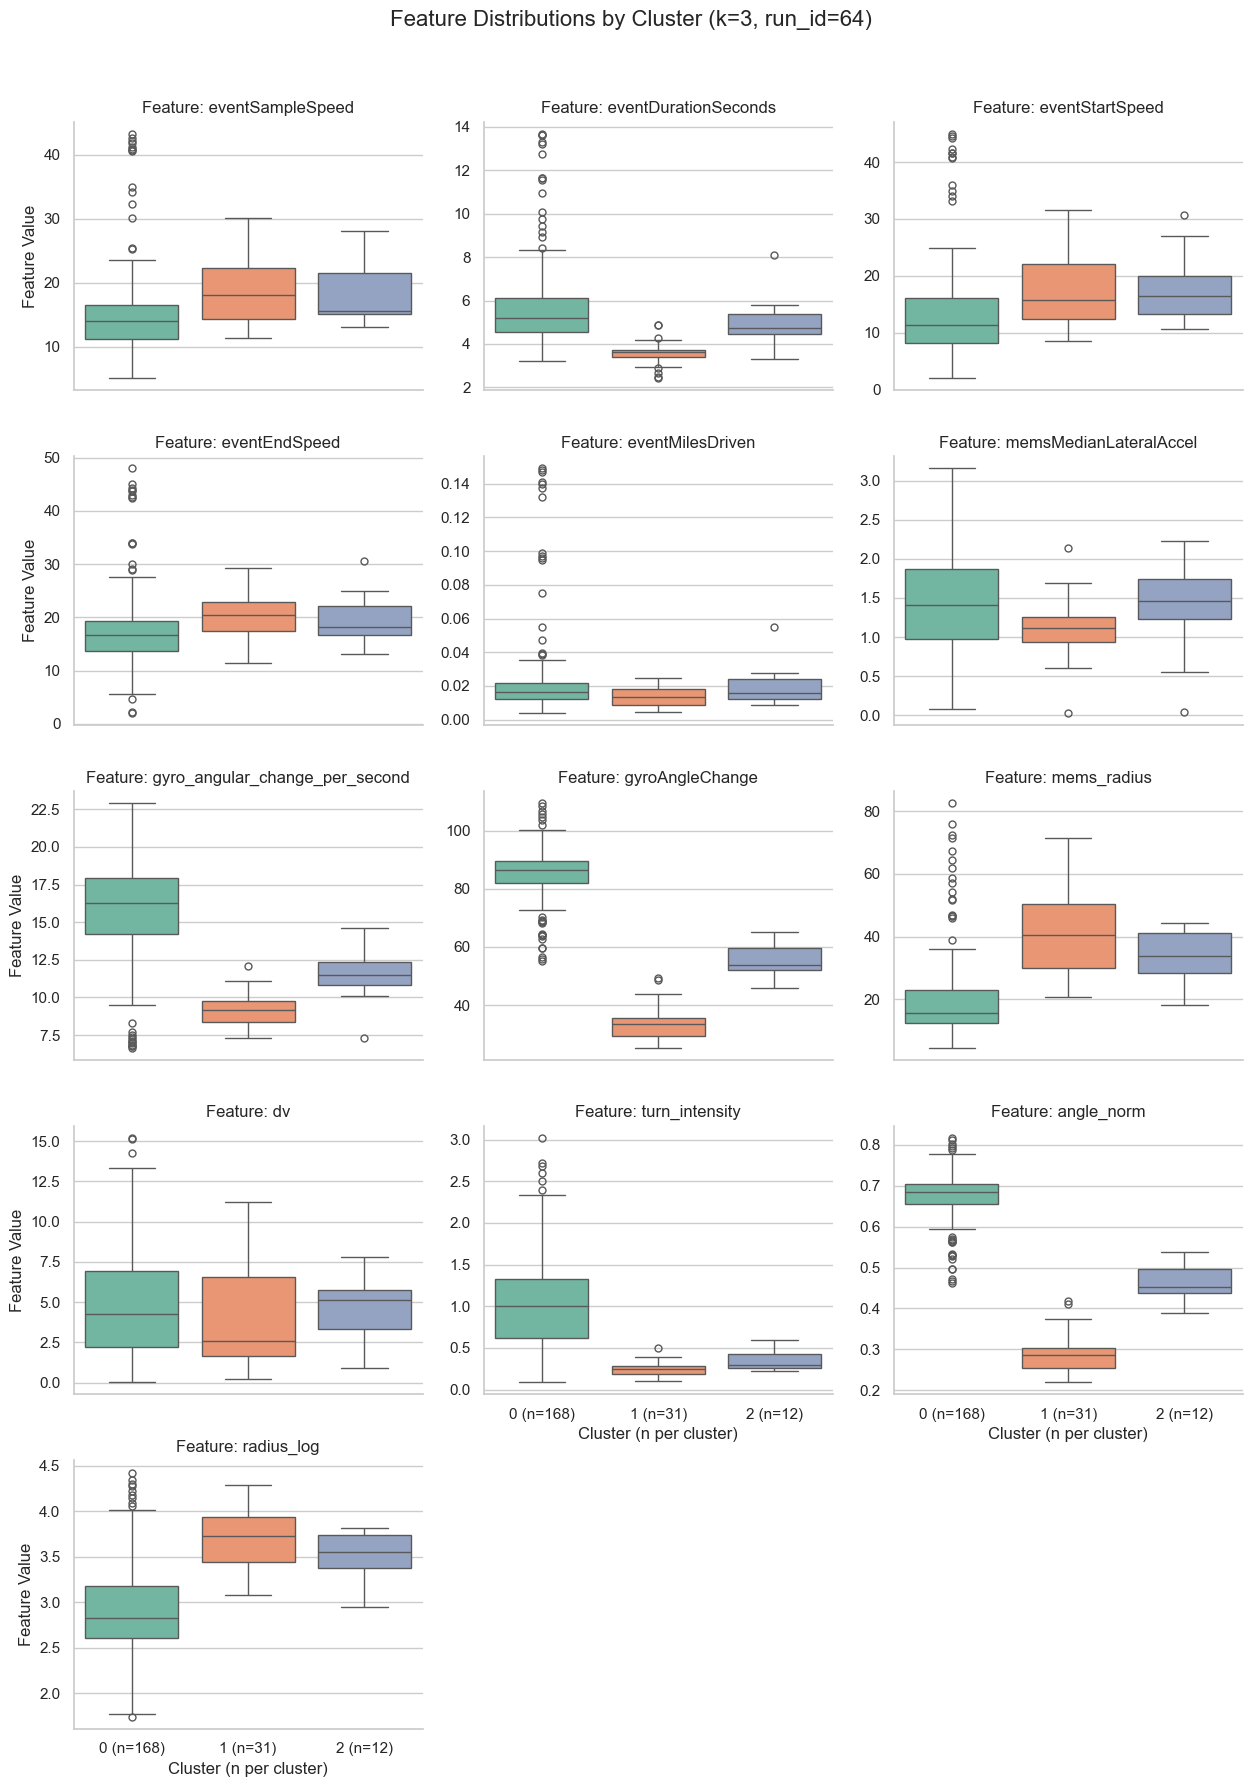

In [38]:
# --- 1) pick which dataframe to use ---
df_with_clusters = full_df.copy()
df_with_clusters['Cluster_Label'] = labels
run_id = 64
labels = run_labels[run_id]
df_with_clusters = full_df.copy()
df_with_clusters['Cluster_Label'] = labels
assert 'Cluster_Label' in df_with_clusters.columns, "You need to attach cluster labels first."

# --- 2) drop noise and build pretty cluster labels with counts ---
df_plot = df_with_clusters[df_with_clusters['Cluster_Label'] != -1].copy()
counts = df_plot['Cluster_Label'].value_counts().sort_index()
label_map = {cl: f"{int(cl)} (n={int(counts.loc[cl])})" for cl in counts.index}
df_plot['Cluster_Str'] = df_plot['Cluster_Label'].map(label_map)

# keep a stable order on x-axis
ordered_xticks = [label_map[cl] for cl in sorted(counts.index)]
df_plot['Cluster_Str'] = pd.Categorical(df_plot['Cluster_Str'], categories=ordered_xticks, ordered=True)

# --- 3) select features to visualize (exclude IDs/GPS/labels) ---
excluded = {'Cluster_Label','Cluster_Str','eventStartLatitude','eventStartLongitude','eventEndLatitude','eventEndLongitude'}
features_to_plot = [c for c in df_plot.columns if c not in excluded and pd.api.types.is_numeric_dtype(df_plot[c])]

# --- 4) reshape to long form for seaborn ---
df_melted = df_plot.melt(
    id_vars='Cluster_Str',
    value_vars=features_to_plot,
    var_name='Feature',
    value_name='Value'
)

# --- 5) plot ---
sns.set(style='whitegrid')
g = sns.catplot(
    data=df_melted,
    x='Cluster_Str',
    y='Value',
    col='Feature',
    kind='box',
    col_wrap=3,
    height=3.5,
    aspect=1.2,
    sharey=False,
    palette='Set2'
)

k = len(counts)
g.fig.suptitle(f'Feature Distributions by Cluster (k={k}, run_id={run_id})', y=1.02, fontsize=16)
g.set_titles('Feature: {col_name}')
g.set_axis_labels('Cluster (n per cluster)', 'Feature Value')
plt.tight_layout()
plt.show()